# CALIPSO Level 1 Data Exploration Notebook

This notebook provides a comprehensive exploration of CALIPSO (Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observation) Level 1 HDF data.

## About CALIPSO
CALIPSO is a NASA satellite mission that uses lidar (laser radar) to study clouds and aerosols in Earth's atmosphere. It provides vertical profiles of backscatter intensity from the surface to ~40 km altitude.

## What You'll Learn
1. **Data Structure**: Understanding HDF4 format and CALIPSO data organization
2. **Visualization Techniques**: 10+ different ways to visualize point cloud/lidar data
3. **Satellite Track Analysis**: Plotting the lat/lon ground track and swath

## Notebook Structure
- **Section 1**: Setup and file selection
- **Section 2**: Data loading and structure analysis
- **Section 3**: 10 different visualization techniques
- **Section 4**: Summary and export options

---
## Section 1: Setup and File Selection

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, PowerNorm
import seaborn as sns
from pyhdf.SD import SD, SDC
import glob
from pathlib import Path
import warnings
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
import plotly.express as px

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure matplotlib for high-quality plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10


In [2]:
# Find all CALIPSO HDF files in the data directory
data_dir = Path('raw')
hdf_files = sorted(glob.glob(str(data_dir / '*.hdf')))

print(f"Found {len(hdf_files)} CALIPSO HDF files:\n")
for i, filepath in enumerate(hdf_files):
    filename = Path(filepath).name
    file_size_mb = Path(filepath).stat().st_size / (1024**2)
    
    # Extract date from filename (format: YYYY-MM-DDTHH-mm-ss)
    try:
        date_part = filename.split('.')[1]
        day_night = filename.split('Z')[1].split('.')[0]  # D or N
        print(f"[{i}] {filename}")
        print(f"    Date: {date_part} UTC ({day_night}='{'Day' if day_night=='D' else 'Night'}')")
        print(f"    Size: {file_size_mb:.1f} MB")
        print()
    except:
        print(f"[{i}] {filename} ({file_size_mb:.1f} MB)")

print("="*80)

Found 7 CALIPSO HDF files:

[0] CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf
    Date: 2023-06-30T16-44-43ZD UTC (D='Day')
    Size: 488.6 MB

[1] CAL_LID_L1-Standard-V4-51.2023-06-30T17-37-28ZN.hdf
    Date: 2023-06-30T17-37-28ZN UTC (N='Night')
    Size: 425.1 MB

[2] CAL_LID_L1-Standard-V4-51.2023-06-30T18-23-08ZD.hdf
    Date: 2023-06-30T18-23-08ZD UTC (D='Day')
    Size: 488.6 MB

[3] CAL_LID_L1-Standard-V4-51.2023-06-30T19-15-53ZN.hdf
    Date: 2023-06-30T19-15-53ZN UTC (N='Night')
    Size: 425.1 MB

[4] CAL_LID_L1-Standard-V4-51.2023-06-30T20-01-33ZD.hdf
    Date: 2023-06-30T20-01-33ZD UTC (D='Day')
    Size: 488.6 MB

[5] CAL_LID_L1-Standard-V4-51.2023-06-30T20-54-18ZN.hdf
    Date: 2023-06-30T20-54-18ZN UTC (N='Night')
    Size: 424.7 MB

[6] CAL_LID_L1-Standard-V4-51.2023-06-30T21-39-53ZD.hdf
    Date: 2023-06-30T21-39-53ZD UTC (D='Day')
    Size: 489.0 MB



In [3]:
# Select a file to analyze
# Change this index to explore different files
FILE_INDEX = 0  # CHANGE THIS to select different file

selected_file = hdf_files[FILE_INDEX]
print(f"Selected file: {Path(selected_file).name}")
print(f"Full path: {selected_file}")

Selected file: CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf
Full path: raw/CAL_LID_L1-Standard-V4-51.2023-06-30T16-44-43ZD.hdf


---
## Section 2: Data Loading & Structure Analysis

CALIPSO Level 1 data is stored in HDF4 format with a specific structure:
- **2D Arrays**: Data organized as `[profiles × altitude_bins]`
- **Profiles**: Along-track measurements (satellite path)
- **Altitude bins**: Vertical samples from -2 km to 40 km
- **Backscatter**: Measured at two wavelengths (532nm and 1064nm)

In [4]:
# Open HDF file and explore structure
hdf = SD(selected_file, SDC.READ)

# Get list of all datasets
datasets = hdf.datasets()

# Display key datasets with details
key_datasets = [
    'Latitude',
    'Longitude', 
    'Profile_Time',
    'Total_Attenuated_Backscatter_532',
    'Attenuated_Backscatter_1064'
]

print("KEY DATASETS:")
print("-" * 80)
for dataset_name in key_datasets:
    if dataset_name in datasets:
        info = datasets[dataset_name]
        dataset = hdf.select(dataset_name)
        shape = dataset.dimensions()
        attrs = dataset.attributes()
        
        print(f"\n{dataset_name}")
        print(f"   Shape: {shape}")
        print(f"   Type: {info[1]}")
        
        # Print some attributes if available
        if 'units' in attrs:
            print(f"   Units: {attrs['units']}")
        if 'valid_range' in attrs:
            print(f"   Valid range: {attrs['valid_range']}")



KEY DATASETS:
--------------------------------------------------------------------------------

Latitude
   Shape: {'fakeDim116': 63840, 'fakeDim117': 1}
   Type: (63840, 1)
   Units: °
   Valid range: -90.0...90.0

Longitude
   Shape: {'fakeDim118': 63840, 'fakeDim119': 1}
   Type: (63840, 1)
   Units: °
   Valid range: -180.0...180.0

Profile_Time
   Shape: {'fakeDim0': 63840, 'fakeDim1': 1}
   Type: (63840, 1)
   Units: s
   Valid range: 4.204E8...1.072E9

Total_Attenuated_Backscatter_532
   Shape: {'fakeDim60': 63840, 'fakeDim61': 583}
   Type: (63840, 583)
   Units: 1/(km · sr)
   Valid range: -0.1...3.3

Attenuated_Backscatter_1064
   Shape: {'fakeDim76': 63840, 'fakeDim77': 583}
   Type: (63840, 583)
   Units: 1/(km · sr)
   Valid range: -0.04...2.5


In [5]:
# Load all key data arrays
print("Loading data arrays...\n")

# Geographic coordinates (1D arrays - one per profile)
latitude = hdf.select('Latitude').get().flatten()
longitude = hdf.select('Longitude').get().flatten()
profile_time = hdf.select('Profile_Time').get().flatten()  # TAI seconds since 1993

# Backscatter data (2D arrays - profiles × altitudes)
backscatter_532 = hdf.select('Total_Attenuated_Backscatter_532').get()
backscatter_1064 = hdf.select('Attenuated_Backscatter_1064').get()

# Close HDF file
hdf.end()

# Get dimensions
n_profiles, n_altitudes = backscatter_532.shape

# Generate altitude array (CALIPSO standard: -2.0 to 40.0 km, 583 bins)
altitudes = np.linspace(-2.0, 40.0, n_altitudes)

# Calculate along-track distance (approximate: CALIPSO samples every ~333m)
distance_km = np.arange(n_profiles) * 0.333  # km

print("="*80)
print("DATA SUMMARY")
print("="*80)
print(f"\nDIMENSIONS:")
print(f"   Number of profiles (along-track): {n_profiles:,}")
print(f"   Number of altitude bins: {n_altitudes}")
print(f"   Total data points: {n_profiles * n_altitudes:,}")
print(f"   Along-track distance: {distance_km[-1]:.1f} km")

print(f"\nGEOGRAPHIC EXTENT:")
print(f"   Latitude:  {latitude.min():7.2f}° to {latitude.max():7.2f}°  (Δ = {latitude.max()-latitude.min():.2f}°)")
print(f"   Longitude: {longitude.min():7.2f}° to {longitude.max():7.2f}°  (Δ = {abs(longitude.max()-longitude.min()):.2f}°)")
print(f"   Altitude:  {altitudes.min():7.2f} to {altitudes.max():7.2f} km")

print(f"\nTEMPORAL COVERAGE:")
time_span_minutes = (profile_time.max() - profile_time.min()) / 60
print(f"   Duration: {time_span_minutes:.1f} minutes")
print(f"   TAI time range: {profile_time.min():.2f} to {profile_time.max():.2f} seconds")

print(f"\nBACKSCATTER STATISTICS (532nm):")
bs532_valid = backscatter_532[(backscatter_532 > -0.1) & (backscatter_532 < 3.3)]
print(f"   Valid points: {len(bs532_valid):,} / {backscatter_532.size:,} ({100*len(bs532_valid)/backscatter_532.size:.1f}%)")
print(f"   Range: {bs532_valid.min():.4f} to {bs532_valid.max():.4f} km⁻¹·sr⁻¹")
print(f"   Mean:  {bs532_valid.mean():.4f} km⁻¹·sr⁻¹")
print(f"   Median: {np.median(bs532_valid):.4f} km⁻¹·sr⁻¹")

print(f"\nBACKSCATTER STATISTICS (1064nm):")
bs1064_valid = backscatter_1064[(backscatter_1064 > -0.04) & (backscatter_1064 < 2.5)]
print(f"   Valid points: {len(bs1064_valid):,} / {backscatter_1064.size:,} ({100*len(bs1064_valid)/backscatter_1064.size:.1f}%)")
print(f"   Range: {bs1064_valid.min():.4f} to {bs1064_valid.max():.4f} km⁻¹·sr⁻¹")
print(f"   Mean:  {bs1064_valid.mean():.4f} km⁻¹·sr⁻¹")
print(f"   Median: {np.median(bs1064_valid):.4f} km⁻¹·sr⁻¹")


Loading data arrays...

DATA SUMMARY

DIMENSIONS:
   Number of profiles (along-track): 63,840
   Number of altitude bins: 583
   Total data points: 37,218,720
   Along-track distance: 21258.4 km

GEOGRAPHIC EXTENT:
   Latitude:   -55.05° to   81.67°  (Δ = 136.72°)
   Longitude: -180.00° to  180.00°  (Δ = 359.99°)
   Altitude:    -2.00 to   40.00 km

TEMPORAL COVERAGE:
   Duration: 52.8 minutes
   TAI time range: 962297090.02 to 962300256.39 seconds

BACKSCATTER STATISTICS (532nm):
   Valid points: 37,170,421 / 37,218,720 (99.9%)
   Range: -0.1000 to 3.2949 km⁻¹·sr⁻¹
   Mean:  0.0025 km⁻¹·sr⁻¹
   Median: 0.0001 km⁻¹·sr⁻¹

BACKSCATTER STATISTICS (1064nm):
   Valid points: 35,063,745 / 37,218,720 (94.2%)
   Range: -0.0400 to 1.9600 km⁻¹·sr⁻¹
   Mean:  0.0033 km⁻¹·sr⁻¹
   Median: 0.0001 km⁻¹·sr⁻¹


---
## Section 3: Visualization Gallery

We'll explore 10 different techniques for visualizing CALIPSO point cloud data:

1. **Backscatter Curtain** - Standard vertical cross-section
2. **Ground Track Map** - Geographic context with lat/lon swath
3. **Dual-Wavelength Comparison** - 532nm vs 1064nm side-by-side
4. **Vertical Profile** - Detailed single-location analysis
5. **Mean Vertical Profile** - Statistical average with variability
6. **Color Ratio Curtain** - Particle type identification
7. **Backscatter Histograms** - Data distribution and quality
8. **Altitude-Backscatter Density** - 2D pattern analysis
9. **Interactive Track** - Plotly-based exploration
10. **Comprehensive Dashboard** - Multi-panel overview

### Plot 1: Backscatter Curtain (Primary CALIPSO Visualization)

This is the standard way to visualize CALIPSO data. It shows:
- **X-axis**: Along-track distance (and latitude)
- **Y-axis**: Altitude
- **Color**: Backscatter intensity (logarithmic scale)

Clouds and aerosol layers appear as bright features.

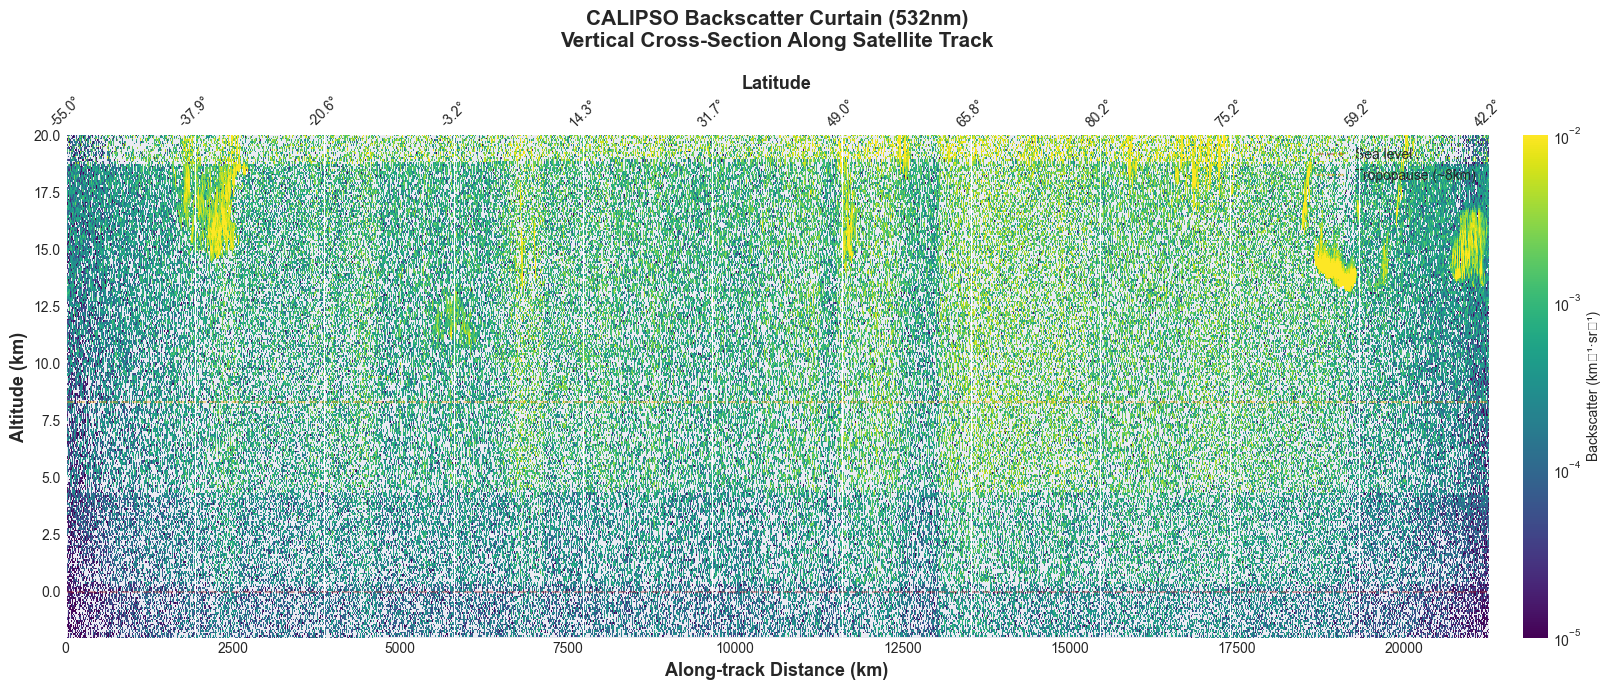

In [6]:
# Create mesh grid for pcolormesh
X, Y = np.meshgrid(distance_km, altitudes)

fig, ax = plt.subplots(figsize=(18, 7))

# Plot curtain with logarithmic color scale
pcm = ax.pcolormesh(X, Y, backscatter_532.T, 
                    cmap='viridis',
                    norm=LogNorm(vmin=1e-5, vmax=1e-2),
                    shading='auto')

ax.set_xlabel('Along-track Distance (km)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title('CALIPSO Backscatter Curtain (532nm)\nVertical Cross-Section Along Satellite Track', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(-2, 20)  # Focus on troposphere and lower stratosphere
ax.grid(True, alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(pcm, ax=ax, label='Backscatter (km⁻¹·sr⁻¹)', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Add secondary x-axis with latitude labels
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
# Sample latitudes at regular intervals
tick_indices = np.linspace(0, len(latitude)-1, 12, dtype=int)
tick_distances = distance_km[tick_indices]
tick_labels = [f"{latitude[i]:.1f}°" for i in tick_indices]
ax2.set_xticks(tick_distances)
ax2.set_xticklabels(tick_labels, rotation=45)
ax2.set_xlabel('Latitude', fontsize=13, fontweight='bold')

# Add atmospheric layer reference lines
ax.axhline(y=0, color='brown', linestyle='--', alpha=0.4, linewidth=1.5, label='Sea level')
ax.axhline(y=8.3, color='orange', linestyle='--', alpha=0.4, linewidth=1.5, label='Tropopause (~8km)')
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


### Plot 2: Ground Track Map (Lat/Lon Swath Visualization)

This shows the satellite's path across the Earth's surface. Points are colored by column-integrated backscatter to show where clouds/aerosols are present.

💡 Interpretation:
   • Track length: ~21258 km
   • Latitude span: -55.0° to 81.7°
   • Longitude span: -180.0° to 180.0°
   • Bright colors = more clouds/aerosols in vertical column
   • Dark colors = clearer atmosphere


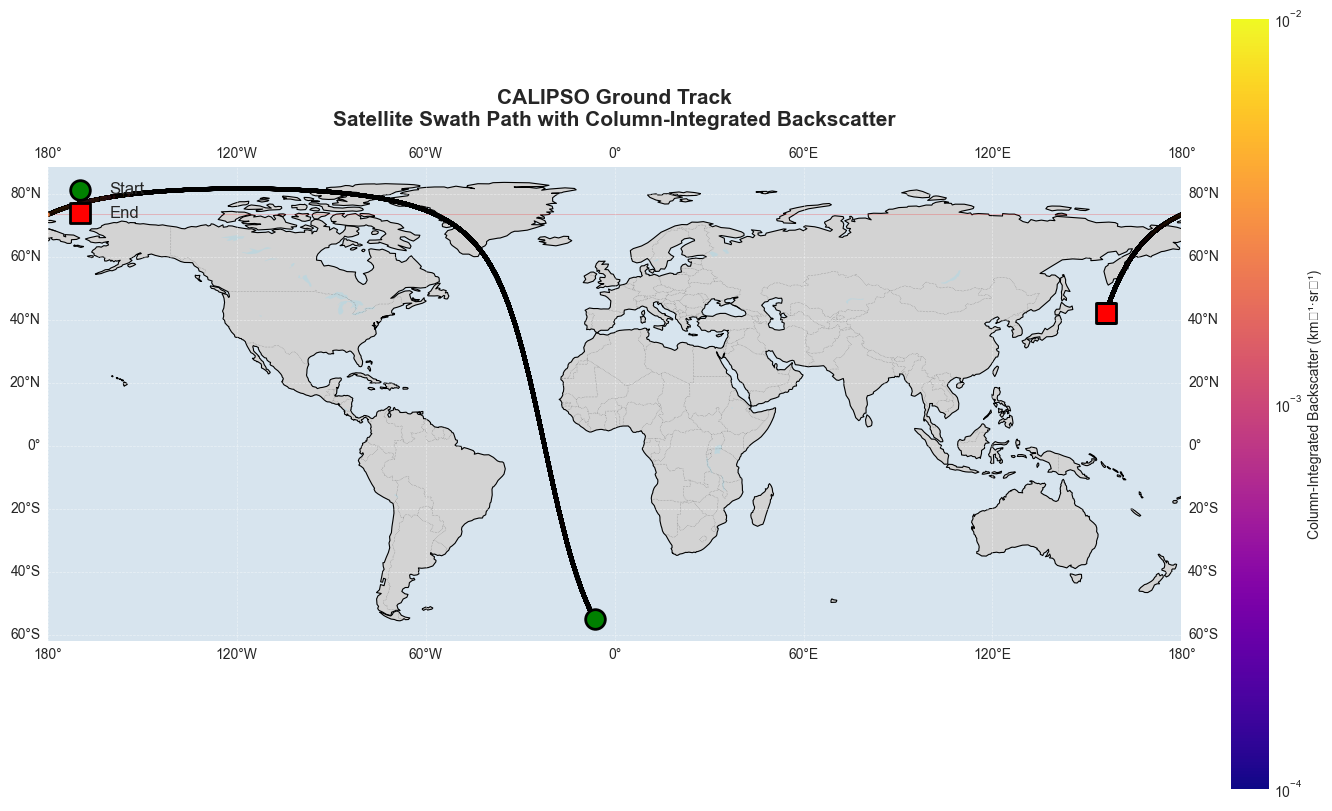

In [7]:
# Calculate column-integrated backscatter as color metric
column_integrated = np.nanmean(backscatter_532, axis=1)


# Create map with Cartopy (better projection and features)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3, zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray', linestyle=':', zorder=1)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', alpha=0.5, zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

# Plot satellite track
scatter = ax.scatter(longitude, latitude, 
                    c=column_integrated,
                    cmap='plasma',
                    s=8,
                    transform=ccrs.PlateCarree(),
                    norm=LogNorm(vmin=1e-4, vmax=1e-2),
                    edgecolors='black',
                    linewidths=0.2,
                    zorder=2)

# Draw line connecting points to show track direction
ax.plot(longitude, latitude, 
        color='red', 
        linewidth=0.5, 
        alpha=0.3,
        transform=ccrs.PlateCarree(),
        zorder=1)

# Add start and end markers
ax.scatter(longitude[0], latitude[0], 
            marker='o', s=200, c='green', 
            edgecolors='black', linewidths=2,
            transform=ccrs.PlateCarree(), 
            zorder=3, label='Start')
ax.scatter(longitude[-1], latitude[-1], 
            marker='s', s=200, c='red', 
            edgecolors='black', linewidths=2,
            transform=ccrs.PlateCarree(), 
            zorder=3, label='End')

ax.set_title('CALIPSO Ground Track\nSatellite Swath Path with Column-Integrated Backscatter', 
            fontsize=15, fontweight='bold', pad=15)

cbar = plt.colorbar(scatter, ax=ax, label='Column-Integrated Backscatter (km⁻¹·sr⁻¹)', 
                    fraction=0.046, pad=0.04)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)

print("💡 Interpretation:")
print(f"   • Track length: ~{distance_km[-1]:.0f} km")
print(f"   • Latitude span: {latitude.min():.1f}° to {latitude.max():.1f}°")
print(f"   • Longitude span: {longitude.min():.1f}° to {longitude.max():.1f}°")
print("   • Bright colors = more clouds/aerosols in vertical column")
print("   • Dark colors = clearer atmosphere")

### Plot 3: Dual-Wavelength Comparison

Comparing 532nm and 1064nm backscatter helps identify particle types:
- **Similar values**: Large particles (clouds)
- **532nm >> 1064nm**: Small particles (aerosols)
- **Different patterns**: Ice vs water clouds

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# 532nm curtain
pcm1 = ax1.pcolormesh(X, Y, backscatter_532.T, 
                      cmap='viridis',
                      norm=LogNorm(vmin=1e-4, vmax=1e-2),
                      shading='auto')
ax1.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
ax1.set_title('532nm Backscatter (Green Wavelength)', fontsize=14, fontweight='bold')
ax1.set_ylim(-2, 20)
ax1.grid(True, alpha=0.3, linestyle='--')
cbar1 = plt.colorbar(pcm1, ax=ax1, label='Backscatter (km⁻¹·sr⁻¹)')

# 1064nm curtain  
pcm2 = ax2.pcolormesh(X, Y, backscatter_1064.T, 
                      cmap='viridis',
                      norm=LogNorm(vmin=1e-4, vmax=1e-2),
                      shading='auto')
ax2.set_xlabel('Along-track Distance (km)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Altitude (km)', fontsize=12, fontweight='bold')
ax2.set_title('1064nm Backscatter (Infrared Wavelength)', fontsize=14, fontweight='bold')
ax2.set_ylim(-2, 20)
ax2.grid(True, alpha=0.3, linestyle='--')
cbar2 = plt.colorbar(pcm2, ax=ax2, label='Backscatter (km⁻¹·sr⁻¹)')

fig.suptitle('Dual-Wavelength Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   • Look for differences between the two panels")
print("   • Strong signal in both = large particles (clouds)")
print("   • Strong at 532nm, weak at 1064nm = small particles (aerosols)")
print("   • Different spatial patterns can indicate different particle types")

💡 Interpretation:
   • Look for differences between the two panels
   • Strong signal in both = large particles (clouds)
   • Strong at 532nm, weak at 1064nm = small particles (aerosols)
   • Different spatial patterns can indicate different particle types


### Plot 4: Vertical Profile Analysis

Examine the vertical structure at a specific location along the track.

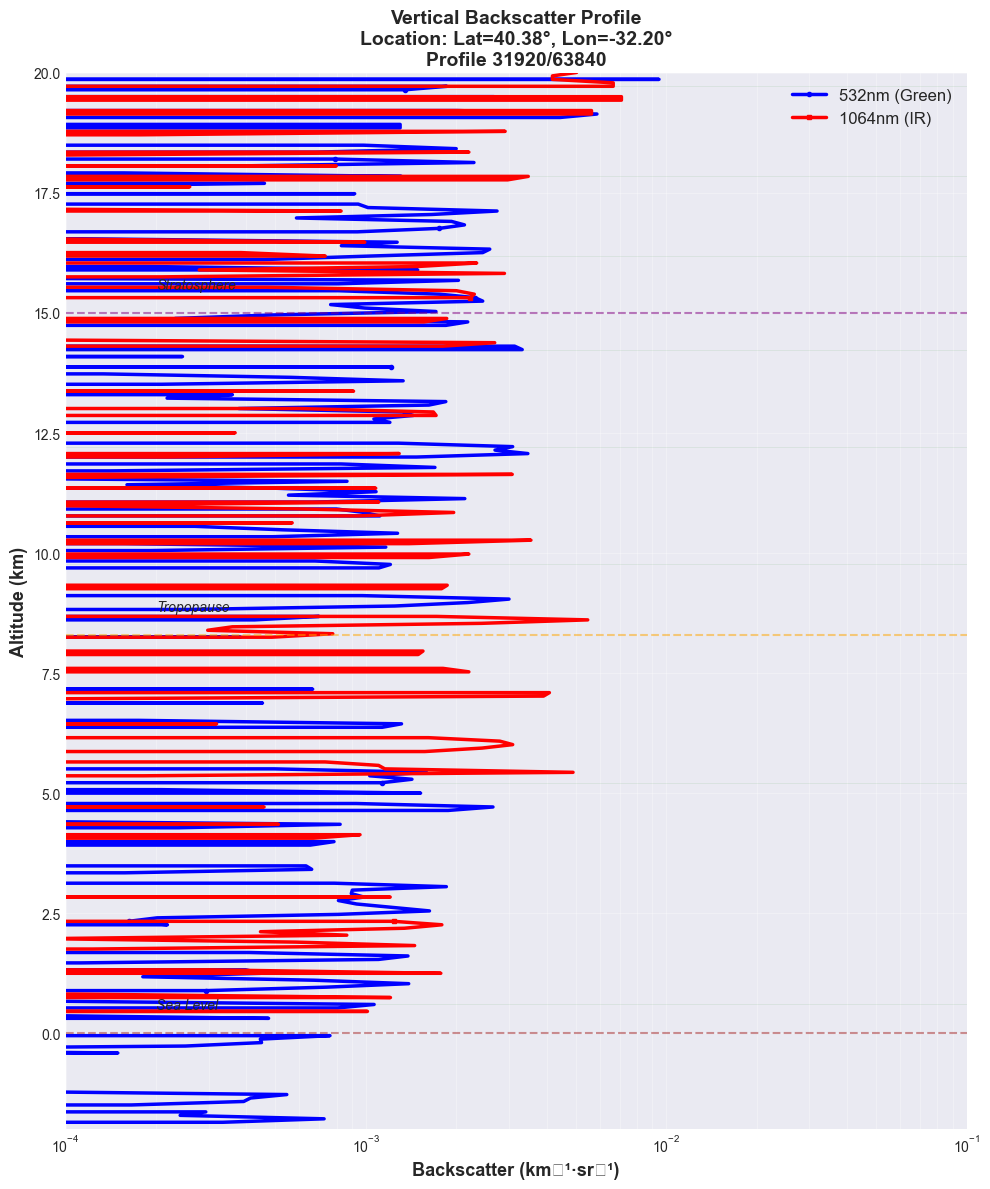

💡 Profile Analysis at index 31920:
   Location: 40.38°N, -32.20°E
   Distance along track: 10629.4 km
   Features detected (>1e-3): 202 altitude bins
   Feature altitude range: 0.6 to 39.8 km


In [9]:
# Select profile to analyze (middle of track)
profile_index = n_profiles // 2

fig, ax = plt.subplots(figsize=(10, 12))

# Plot both wavelengths
ax.plot(backscatter_532[profile_index, :], altitudes, 
        label='532nm (Green)', linewidth=2.5, color='blue', marker='o', 
        markersize=3, markevery=20)
ax.plot(backscatter_1064[profile_index, :], altitudes, 
        label='1064nm (IR)', linewidth=2.5, color='red', marker='s', 
        markersize=3, markevery=20)

ax.set_xlabel('Backscatter (km⁻¹·sr⁻¹)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title(f'Vertical Backscatter Profile\nLocation: Lat={latitude[profile_index]:.2f}°, Lon={longitude[profile_index]:.2f}°\nProfile {profile_index}/{n_profiles}', 
             fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_xlim(1e-4, 1e-1)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=12, loc='upper right')

# Add atmospheric layer annotations
ax.axhline(y=0, color='brown', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2e-4, 0.5, 'Sea Level', fontsize=10, style='italic')

ax.axhline(y=8.3, color='orange', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2e-4, 8.8, 'Tropopause', fontsize=10, style='italic')

ax.axhline(y=15, color='purple', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2e-4, 15.5, 'Stratosphere', fontsize=10, style='italic')

# Highlight significant features
threshold = 1e-3
feature_altitudes = altitudes[backscatter_532[profile_index, :] > threshold]
if len(feature_altitudes) > 0:
    for alt in feature_altitudes[::10]:  # Mark every 10th feature point
        ax.axhline(y=alt, color='green', alpha=0.1, linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"💡 Profile Analysis at index {profile_index}:")
print(f"   Location: {latitude[profile_index]:.2f}°N, {longitude[profile_index]:.2f}°E")
print(f"   Distance along track: {distance_km[profile_index]:.1f} km")
print(f"   Features detected (>1e-3): {len(feature_altitudes)} altitude bins")
if len(feature_altitudes) > 0:
    print(f"   Feature altitude range: {feature_altitudes.min():.1f} to {feature_altitudes.max():.1f} km")

### Plot 5: Mean Vertical Profile with Variability

Statistical summary showing the typical atmospheric structure across all profiles.

In [10]:
# Calculate statistics
mean_profile_532 = np.nanmean(backscatter_532, axis=0)
std_profile_532 = np.nanstd(backscatter_532, axis=0)
median_profile_532 = np.nanmedian(backscatter_532, axis=0)
p25_profile_532 = np.nanpercentile(backscatter_532, 25, axis=0)
p75_profile_532 = np.nanpercentile(backscatter_532, 75, axis=0)

fig, ax = plt.subplots(figsize=(10, 12))

# Plot mean and median
ax.plot(mean_profile_532, altitudes, 
        label='Mean', linewidth=3, color='blue', zorder=3)
ax.plot(median_profile_532, altitudes, 
        label='Median', linewidth=2.5, color='green', 
        linestyle='--', zorder=3)

# Add percentile shading (25th to 75th)
ax.fill_betweenx(altitudes, p25_profile_532, p75_profile_532,
                 alpha=0.3, color='cyan', label='25th-75th percentile', zorder=1)

# Add standard deviation shading
ax.fill_betweenx(altitudes, 
                 np.maximum(mean_profile_532 - std_profile_532, 1e-5),
                 mean_profile_532 + std_profile_532,
                 alpha=0.2, color='blue', label='±1σ', zorder=2)

ax.set_xlabel('Backscatter (km⁻¹·sr⁻¹)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title(f'Mean Vertical Profile (All {n_profiles:,} Profiles)\n532nm Backscatter Statistics', 
             fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_xlim(1e-4, 1e-1)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

print("💡 Statistical Summary:")
print(f"   Mean backscatter (all altitudes): {np.nanmean(mean_profile_532):.2e} km⁻¹·sr⁻¹")
print(f"   Peak altitude (max mean backscatter): {altitudes[np.nanargmax(mean_profile_532)]:.1f} km")
print(f"   Boundary layer top (approx): ~{altitudes[np.nanargmax(mean_profile_532[:200])]:.1f} km")

💡 Statistical Summary:
   Mean backscatter (all altitudes): -1.30e+01 km⁻¹·sr⁻¹
   Peak altitude (max mean backscatter): 38.6 km
   Boundary layer top (approx): ~12.2 km


### Plot 6: Color Ratio Curtain

The color ratio (1064nm / 532nm) helps identify particle types:
- **Ratio < 0.5**: Small aerosol particles
- **Ratio ~ 1.0**: Large cloud droplets
- **Ratio intermediate**: Ice crystals or mixed particles

In [ ]:
# Calculate color ratio with proper masking
with np.errstate(divide='ignore', invalid='ignore'):
    color_ratio = backscatter_1064 / backscatter_532
    color_ratio = np.ma.masked_invalid(color_ratio)
    # Mask out values where backscatter is too low (noisy ratio)
    color_ratio = np.ma.masked_where((backscatter_532 < 1e-4) | (backscatter_1064 < 1e-4), color_ratio)

fig, ax = plt.subplots(figsize=(18, 7))

# Use diverging colormap centered on 1.0
pcm = ax.pcolormesh(X, Y, color_ratio.T, 
                    cmap='RdYlBu_r',
                    vmin=0, vmax=2,
                    shading='auto')

ax.set_xlabel('Along-track Distance (km)', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title('Color Ratio Curtain (1064nm / 532nm)\nParticle Type Discrimination', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, linestyle='--')

cbar = plt.colorbar(pcm, ax=ax, label='Color Ratio', extend='both')

# Add reference lines to colorbar
cbar.ax.axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='Aerosol')
cbar.ax.axhline(y=1.0, color='black', linestyle='-', linewidth=2, label='Equal')
cbar.ax.text(1.05, 0.5, 'Aerosol', transform=cbar.ax.transData, 
            fontsize=9, ha='left', va='center', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
cbar.ax.text(1.05, 1.0, 'Cloud', transform=cbar.ax.transData, 
            fontsize=9, ha='left', va='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   • Blue colors (ratio < 0.5): Small particles (aerosols, smoke)")
print("   • White/Yellow (ratio ~ 1.0): Large particles (cloud droplets)")
print("   • Red colors (ratio > 1.0): Rare, possibly instrument artifacts or very specific conditions")

### Plot 7: Backscatter Distribution Histograms

Understanding the statistical distribution helps with:
- Data quality assessment
- Threshold selection
- Identifying anomalies

In [ ]:
# Filter valid data
bs532_flat = backscatter_532[(backscatter_532 > -0.1) & (backscatter_532 < 3.3)].flatten()
bs1064_flat = backscatter_1064[(backscatter_1064 > -0.04) & (backscatter_1064 < 2.5)].flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 532nm histogram
counts1, bins1, patches1 = ax1.hist(bs532_flat, bins=100, color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Backscatter (km⁻¹·sr⁻¹)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
ax1.set_title('532nm Backscatter Distribution', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, which='both')

# Add statistics annotations
stats_text1 = f'Mean: {bs532_flat.mean():.2e}\nMedian: {np.median(bs532_flat):.2e}\nStd: {bs532_flat.std():.2e}'
ax1.text(0.98, 0.97, stats_text1, transform=ax1.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 1064nm histogram
counts2, bins2, patches2 = ax2.hist(bs1064_flat, bins=100, color='red', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Backscatter (km⁻¹·sr⁻¹)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('1064nm Backscatter Distribution', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

# Add statistics annotations
stats_text2 = f'Mean: {bs1064_flat.mean():.2e}\nMedian: {np.median(bs1064_flat):.2e}\nStd: {bs1064_flat.std():.2e}'
ax2.text(0.98, 0.97, stats_text2, transform=ax2.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

fig.suptitle('Backscatter Value Distributions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("💡 Statistical Summary:")
print(f"   532nm: {len(bs532_flat):,} valid points")
print(f"   1064nm: {len(bs1064_flat):,} valid points")
print(f"   Typical values: 1e-4 to 1e-2 km⁻¹·sr⁻¹")

### Plot 8: Altitude-Backscatter Density (Hexbin)

This 2D density plot reveals typical backscatter values at different altitudes.

In [ ]:
# Prepare data
alt_expanded = np.tile(altitudes, n_profiles)
bs_flat = backscatter_532.flatten()

# Filter valid data
valid = (bs_flat > 1e-4) & (bs_flat < 1e0)
alt_valid = alt_expanded[valid]
bs_valid = bs_flat[valid]

fig, ax = plt.subplots(figsize=(12, 10))

# Create hexbin plot
hexbin = ax.hexbin(np.log10(bs_valid), alt_valid, 
                   gridsize=80, 
                   cmap='YlOrRd',
                   mincnt=1,
                   edgecolors='black',
                   linewidths=0.2)

ax.set_xlabel('log₁₀(Backscatter) [km⁻¹·sr⁻¹]', fontsize=13, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=13, fontweight='bold')
ax.set_title('Altitude vs Backscatter Density\nReveals Typical Atmospheric Layers', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_ylim(-2, 20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add reference lines
ax.axhline(y=0, color='brown', linestyle='--', alpha=0.5, linewidth=1.5, label='Sea level')
ax.axhline(y=8.3, color='blue', linestyle='--', alpha=0.5, linewidth=1.5, label='Tropopause')

cbar = plt.colorbar(hexbin, ax=ax, label='Point Density (log scale)')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

print("💡 Interpretation:")
print("   • Bright regions = common altitude/backscatter combinations")
print("   • Horizontal bands = persistent atmospheric layers")
print("   • Vertical spread at altitude = variability in backscatter at that height")
print(f"   • Analyzed {len(bs_valid):,} valid points")

### Plot 9: Interactive Track (Plotly)

Interactive visualization allows zooming, panning, and hovering for detailed information.

*Note: This plot is interactive in Jupyter. Try hovering over points and using the zoom tools!*

In [ ]:
if PLOTLY_AVAILABLE:
    # Create interactive map
    fig = go.Figure(go.Scattermapbox(
        lat=latitude,
        lon=longitude,
        mode='markers',
        marker=dict(
            size=6,
            color=np.log10(column_integrated),
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(
                title="log₁₀(Backscatter)<br>km⁻¹·sr⁻¹",
                x=1.02
            ),
            cmin=-4,
            cmax=-2
        ),
        text=[f"<b>Profile {i}</b><br>"
              f"Lat: {la:.3f}°<br>"
              f"Lon: {lo:.3f}°<br>"
              f"Column Backscatter: {bs:.2e} km⁻¹·sr⁻¹<br>"
              f"Time: {t:.1f} sec (TAI)<br>"
              f"Distance: {d:.1f} km" 
              for i, (la, lo, bs, t, d) in enumerate(zip(latitude, longitude, column_integrated, profile_time, distance_km))],
        hoverinfo='text'
    ))
    
    fig.update_layout(
        title=dict(
            text='<b>CALIPSO Ground Track (Interactive)</b><br><sub>Hover for details | Scroll to zoom | Drag to pan</sub>',
            x=0.5,
            xanchor='center'
        ),
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=np.mean(latitude), lon=np.mean(longitude)),
            zoom=2
        ),
        height=700,
        margin=dict(l=0, r=0, t=60, b=0)
    )
    
    fig.show()
    
    print("✅ Interactive map created! Try:")
    print("   • Hover over points for detailed information")
    print("   • Scroll to zoom in/out")
    print("   • Click and drag to pan")
    print("   • Double-click to reset view")
else:
    print("❌ Plotly not available. Install with: pip install plotly")
    print("   Showing static map instead...")
    
    # Fallback to matplotlib
    fig, ax = plt.subplots(figsize=(14, 8))
    scatter = ax.scatter(longitude, latitude, c=np.log10(column_integrated), 
                        cmap='plasma', s=20, edgecolors='black', linewidths=0.2)
    ax.plot(longitude, latitude, 'r-', linewidth=0.5, alpha=0.3)
    ax.set_xlabel('Longitude (°)', fontweight='bold')
    ax.set_ylabel('Latitude (°)', fontweight='bold')
    ax.set_title('CALIPSO Ground Track (Static)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='log₁₀(Backscatter)')
    plt.tight_layout()
    plt.show()

### Plot 10: Comprehensive Analysis Dashboard

This multi-panel figure combines multiple visualization techniques for a complete overview.

In [ ]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Main curtain plot (top, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
pcm1 = ax1.pcolormesh(X, Y, backscatter_532.T, 
                      cmap='viridis',
                      norm=LogNorm(vmin=1e-4, vmax=1e-2),
                      shading='auto')
ax1.set_ylabel('Altitude (km)', fontweight='bold')
ax1.set_title('532nm Backscatter Curtain', fontsize=12, fontweight='bold')
ax1.set_ylim(-2, 15)
ax1.grid(True, alpha=0.3)
plt.colorbar(pcm1, ax=ax1, label='Backscatter', fraction=0.046, pad=0.04)

# 2. Ground track (top right)
ax2 = fig.add_subplot(gs[0, 2])
scatter2 = ax2.scatter(longitude, latitude, c=np.log10(column_integrated), 
                      s=10, cmap='plasma', edgecolors='none')
ax2.plot(longitude, latitude, 'r-', linewidth=0.5, alpha=0.3)
ax2.scatter(longitude[0], latitude[0], marker='o', s=100, c='green', edgecolors='black', linewidths=1, zorder=3)
ax2.scatter(longitude[-1], latitude[-1], marker='s', s=100, c='red', edgecolors='black', linewidths=1, zorder=3)
ax2.set_xlabel('Longitude', fontsize=9, fontweight='bold')
ax2.set_ylabel('Latitude', fontsize=9, fontweight='bold')
ax2.set_title('Ground Track', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Mean vertical profile (middle left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(mean_profile_532, altitudes, linewidth=2.5, color='blue')
ax3.fill_betweenx(altitudes, p25_profile_532, p75_profile_532, alpha=0.3, color='cyan')
ax3.set_xlabel('Backscatter', fontsize=9, fontweight='bold')
ax3.set_ylabel('Altitude (km)', fontsize=9, fontweight='bold')
ax3.set_title('Mean Profile', fontsize=12, fontweight='bold')
ax3.set_xscale('log')
ax3.set_ylim(-2, 15)
ax3.grid(True, alpha=0.3)

# 4. Histogram (middle center)
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(np.log10(bs532_flat), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax4.set_xlabel('log₁₀(Backscatter)', fontsize=9, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=9, fontweight='bold')
ax4.set_title('Backscatter Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Color ratio profile (middle right)
ax5 = fig.add_subplot(gs[1, 2])
with np.errstate(divide='ignore', invalid='ignore'):
    color_ratio_mean = np.nanmean(backscatter_1064 / backscatter_532, axis=0)
ax5.plot(color_ratio_mean, altitudes, linewidth=2.5, color='orange')
ax5.axvline(x=1, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax5.set_xlabel('Color Ratio', fontsize=9, fontweight='bold')
ax5.set_ylabel('Altitude (km)', fontsize=9, fontweight='bold')
ax5.set_title('Mean Color Ratio', fontsize=12, fontweight='bold')
ax5.set_xlim(0, 2)
ax5.set_ylim(-2, 15)
ax5.grid(True, alpha=0.3)

# 6. Feature density (bottom left)
ax6 = fig.add_subplot(gs[2, 0])
feature_counts = np.sum(backscatter_532 > 1e-3, axis=0) / n_profiles
ax6.barh(altitudes, feature_counts, height=0.07, color='teal', edgecolor='black', linewidth=0.5)
ax6.set_xlabel('Feature Frequency', fontsize=9, fontweight='bold')
ax6.set_ylabel('Altitude (km)', fontsize=9, fontweight='bold')
ax6.set_title('Feature Distribution', fontsize=12, fontweight='bold')
ax6.set_ylim(-2, 15)
ax6.grid(True, alpha=0.3, axis='x')

# 7. Data summary (bottom center)
ax7 = fig.add_subplot(gs[2, 1])
ax7.axis('off')
summary_text = f"""
╔══════════════════════════════╗
║     DATA SUMMARY             ║
╚══════════════════════════════╝

Profiles: {n_profiles:,}
Altitude bins: {n_altitudes}
Total points: {n_profiles * n_altitudes:,}

Geographic Coverage:
  Lat: {latitude.min():.2f}° to {latitude.max():.2f}°
  Lon: {longitude.min():.2f}° to {longitude.max():.2f}°
  Track: {distance_km[-1]:.0f} km

532nm Statistics:
  Range: {bs532_valid.min():.2e} to
         {bs532_valid.max():.2e}
  Mean: {bs532_valid.mean():.2e}

1064nm Statistics:
  Range: {bs1064_valid.min():.2e} to
         {bs1064_valid.max():.2e}
  Mean: {bs1064_valid.mean():.2e}
"""
ax7.text(0.05, 0.95, summary_text, fontsize=9, family='monospace',
        verticalalignment='top', transform=ax7.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 8. Wavelength comparison (bottom right)
ax8 = fig.add_subplot(gs[2, 2])
mean_1064 = np.nanmean(backscatter_1064, axis=0)
ax8.plot(mean_profile_532, altitudes, label='532nm', linewidth=2.5, color='blue')
ax8.plot(mean_1064, altitudes, label='1064nm', linewidth=2.5, color='red')
ax8.set_xlabel('Backscatter', fontsize=9, fontweight='bold')
ax8.set_ylabel('Altitude (km)', fontsize=9, fontweight='bold')
ax8.set_title('Wavelength Comparison', fontsize=12, fontweight='bold')
ax8.set_xscale('log')
ax8.set_ylim(-2, 15)
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)

# Main title
filename = Path(selected_file).name
fig.suptitle(f'CALIPSO Data Analysis Dashboard\n{filename}', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('calipso_dashboard.png', dpi=300, bbox_inches='tight')
print("✅ Dashboard saved as 'calipso_dashboard.png'")
plt.show()

---
## Section 4: Summary and Export Options

This notebook demonstrated 10+ different techniques for visualizing CALIPSO point cloud data:

1. ✅ **Backscatter Curtain** - Standard vertical cross-section
2. ✅ **Ground Track Map** - Geographic lat/lon swath visualization
3. ✅ **Dual-Wavelength Comparison** - Side-by-side analysis
4. ✅ **Vertical Profile** - Single-location analysis
5. ✅ **Mean Vertical Profile** - Statistical summary
6. ✅ **Color Ratio Curtain** - Particle discrimination
7. ✅ **Backscatter Histograms** - Distribution analysis
8. ✅ **Altitude-Backscatter Density** - 2D pattern identification
9. ✅ **Interactive Track** - Plotly-based exploration
10. ✅ **Comprehensive Dashboard** - Multi-panel overview

### Key Takeaways

**Data Structure:**
- CALIPSO data is organized as profiles (along-track) × altitudes (vertical)
- Two wavelengths (532nm, 1064nm) provide particle information
- Backscatter values span many orders of magnitude (use log scale!)

**Visualization Best Practices:**
- Use curtain plots for primary analysis
- Always show geographic context (ground track)
- Compare wavelengths for particle identification
- Use statistics (mean, percentiles) for summaries
- Interactive plots enable detailed exploration

**Next Steps:**
- Explore other files by changing `FILE_INDEX`
- Export data to other formats (CSV, NetCDF, LAS, COPC)
- Implement feature detection algorithms
- Create animations of temporal evolution